In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from pandas import json_normalize
import json
import datetime
from scipy.stats import pearsonr

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


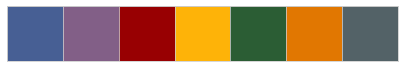

In [4]:
# import custom palette
import my_palette as mp

To begin, I need to munge the data a bit, as it is generalized for use on a variety of problems.

> **MOVIE DATASET**

In [5]:
# read in movie dataset
movie_df = pd.read_json('tmdb_movie_clean.json')
movie_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,171236,171237,171238,171239,171240,171241,171242,171243,171244,171245
budget,4e+06,2.1e+07,42000,1.1e+07,9.4e+07,5.5e+07,1.5e+07,839727,1.28e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
genres,"[Crime, Comedy]","[Action, Thriller, Crime]",[Documentary],"[Adventure, Action, Science Fiction]","[Animation, Family]","[Comedy, Drama, Romance]",[Drama],"[Mystery, Drama]","[Drama, Crime]","[Horror, Thriller, Mystery]",...,[Documentary],[],[],[],[],[Music],[],[Documentary],[],[]
id,5,6,8,11,12,13,14,15,16,17,...,701689,701692,701695,701702,701705,701706,701707,701710,701714,701729
imdb_id,tt0113101,tt0107286,tt0825671,tt0076759,tt0266543,tt0109830,tt0169547,tt0033467,tt0168629,tt0411267,...,None,None,None,None,None,None,None,tt1821695,None,None
overview,It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J...",Timo Novotny labels his new project an experim...,Princess Leia is captured and held hostage by ...,"Nemo, an adventurous young clownfish, is unexp...",A man with a low IQ has accomplished great thi...,"Lester Burnham, a depressed suburban father in...","Newspaper magnate, Charles Foster Kane is take...","Selma, a Czech immigrant on the verge of blind...",Adèle and her daughter Sarah are traveling on ...,...,Set at CREST (the Centre for Research and Educ...,Tom and Jerry is an American animated franchis...,This full concert broadcast comes from our 201...,"Shakespeare's heartbreaking tale, Nureyev's bl...",Courage the Cowardly Dog is an American animat...,"Radiohead's set from June 30, 2017 at the Rock...",‘Rising Silence’ is a journey of relationships...,There are approximately 5.7 million people in ...,"SUM 41 performs live at The House of Blues, Cl...",A tantalising trio of cult lesbian movies from...
popularity,13.532,11.817,2.629,90.645,33.313,33.781,23.513,18.872,16.037,6.766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_date,1995-12-09T00:00:00.000Z,1993-10-15T00:00:00.000Z,2006-01-01T00:00:00.000Z,1977-05-25T00:00:00.000Z,2003-05-30T00:00:00.000Z,1994-07-06T00:00:00.000Z,1999-09-15T00:00:00.000Z,1941-04-30T00:00:00.000Z,2000-05-17T00:00:00.000Z,2005-09-28T00:00:00.000Z,...,2019-12-31T00:00:00.000Z,1940-02-10T00:00:00.000Z,2017-06-01T00:00:00.000Z,None,None,2017-06-30T00:00:00.000Z,None,None,None,2010-10-04T00:00:00.000Z
revenue,4.25735e+06,1.21369e+07,NaN,7.75398e+08,9.40336e+08,6.77388e+08,3.56297e+08,2.32177e+07,4.00319e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
runtime,98,110,80,121,100,142,122,119,141,87,...,80,NaN,NaN,144,NaN,129,75,85,75,140
tagline,Twelve outrageous guests. Four scandalous requ...,Don't move. Don't whisper. Don't even breathe.,A Megacities remix.,"A long time ago in a galaxy far, far away...",There are 3.7 trillion fish in the ocean. They...,Life is like a box of chocolates...you never k...,Look closer.,It's terrific!,You don't need eyes to see.,One of the living for one of the dead.,...,None,None,None,"Shakespeare's heartbreaking tale, Nureyev's bl...",None,None,None,Bipolar and Living,"concert, punk rock, live",None


In [6]:
# convert release dates to datetime objects and remove timezone-aware index
movie_df['release_date'] = pd.to_datetime(movie_df['release_date']).dt.tz_localize(None)
movie_df.head(2).transpose()

,0,1
budget,4e+06,2.1e+07
genres,"[Crime, Comedy]","[Action, Thriller, Crime]"
id,5,6
imdb_id,tt0113101,tt0107286
overview,It's Ted the Bellhop's first night on the job....,"While racing to a boxing match, Frank, Mike, J..."
popularity,13.532,11.817
release_date,1995-12-09 00:00:00,1993-10-15 00:00:00
revenue,4.25735e+06,1.21369e+07
runtime,98,110
tagline,Twelve outrageous guests. Four scandalous requ...,Don't move. Don't whisper. Don't even breathe.


In [7]:
# observe movie DataFrame
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171246 entries, 0 to 171245
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   budget        13635 non-null   float64       
 1   genres        171246 non-null  object        
 2   id            171246 non-null  int64         
 3   imdb_id       129045 non-null  object        
 4   overview      167715 non-null  object        
 5   popularity    171198 non-null  float64       
 6   release_date  152368 non-null  datetime64[ns]
 7   revenue       8309 non-null    float64       
 8   runtime       120310 non-null  float64       
 9   tagline       46123 non-null   object        
 10  title         171246 non-null  object        
 11  vote_average  81872 non-null   float64       
 12  vote_count    82029 non-null   float64       
 13  cast          171246 non-null  object        
 14  crew          171246 non-null  object        
 15  reviews       171

Since I am not looking at text data for this project, I will drop overview, tagline, and reviews columns.<br>
Because I'm not collecting data from other sources, I will drop the IMDb ID column.<br>
Since I am only looking at acting departments, I will not need the crew data.

In [8]:
# drop columns that will not be used
movie_df.drop(
    ['imdb_id', 'overview', 'tagline', 'crew', 'reviews'], 
    axis=1, inplace=True)

In [9]:
# rename TMDb movie ID to distinguish it from actor id's
movie_df.rename(columns={'id': 'movie_id'}, inplace=True)

Since this is all the data I will use for the project, I will drop all rows where any value is missing.

In [10]:
# drop movies with missing data
movie_df.dropna(inplace=True)

I need to check for empty lists in the genres and cast columns.

In [11]:
# count empty cast lists
movie_df['cast'].str.len().eq(0).sum()

13

In [12]:
# remove empty cast lists
movie_df = movie_df[movie_df['cast'].map(lambda d: len(d)) > 0]

In [13]:
# count empty genres lists
movie_df['genres'].str.len().eq(0).sum()

19

In [14]:
# remove empty genres lists
movie_df = movie_df[movie_df['genres'].map(lambda d: len(d)) > 0]

In [15]:
# observe how many movies we have left
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5805 entries, 0 to 169380
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   budget        5805 non-null   float64       
 1   genres        5805 non-null   object        
 2   movie_id      5805 non-null   int64         
 3   popularity    5805 non-null   float64       
 4   release_date  5805 non-null   datetime64[ns]
 5   revenue       5805 non-null   float64       
 6   runtime       5805 non-null   float64       
 7   title         5805 non-null   object        
 8   vote_average  5805 non-null   float64       
 9   vote_count    5805 non-null   float64       
 10  cast          5805 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(3)
memory usage: 544.2+ KB


In [16]:
# observe numerical values
movie_df.describe()

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count
count,5.805000e+03,5805.00000,5805.000000,5.805000e+03,5805.000000,5805.000000,5805.000000
mean,3.200695e+07,90452.89509,13.760122,9.449903e+07,108.505254,6.409716,1541.706977
std,4.165488e+07,144658.94179,11.388139,1.811366e+08,20.417376,0.983087,2553.825764
min,1.000000e+00,5.00000,0.600000,1.000000e+00,70.000000,1.000000,1.000000
25%,5.000000e+06,9339.00000,8.498000,5.634828e+06,95.000000,5.800000,152.000000
50%,1.775977e+07,16668.00000,12.828000,2.978900e+07,105.000000,6.400000,589.000000
75%,4.000000e+07,84174.00000,16.806000,1.020000e+08,118.000000,7.000000,1748.000000
max,3.800000e+08,691633.00000,448.572000,2.797801e+09,338.000000,10.000000,25603.000000


The budget and revenue each have minimum values of $1.<br>
I will examine this and determine reasonable minimum values to accept, if necessary.

The popularity feature is dynamic through time.<br>
It is a TMDb feature that fluxuates with the user activity with respect to each movie.<br>
It's range looks appropriate.

The runtime looks good, as it has the minimum length allowable for a feature length movie.<br>
I will look closer at the movies with long runtimes for errors.

The vote average is from one to ten, which looks good.<br>
The vote counts are the total number of votes with respect to each movie.<br>
This feature looks good, as well.

> **Monetary Errors**

Monetary figures for some movies have been carelessly recorded at TMDb without the proper decimal scale.<br>
I know from previous analysis of this dataseet that budgets and revenues will be highly correlated.<br>
So, I will only be concerned with errors of scale that have been imposed on one of them but not the other.<br>
I will show a few of these for clarity.

In [17]:
# observe movies that returned < 10% of their investments back and had revenues < $1000
movie_df.loc[(np.divide(
    movie_df['budget'], movie_df['revenue']) > 10) 
             & (movie_df['revenue'] < 1000)].head()

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast
1403,2200000.0,"[Drama, Music, Comedy]",3121,8.758,1975-06-11,10.0,160.0,Nashville,7.4,185.0,"[{'cast_id': 20, 'character': 'Norman', 'credi..."
2093,68000000.0,"[Drama, Horror, Science Fiction, Thriller]",6171,16.179,2003-03-21,75.0,136.0,Dreamcatcher,5.4,1092.0,"[{'cast_id': 2, 'character': 'Col. Abraham Cur..."
2340,30000000.0,"[Action, Science Fiction, Thriller]",7916,9.296,2008-10-02,743.0,95.0,Far Cry,3.6,154.0,"[{'cast_id': 1, 'character': 'Jack Carver', 'c..."
4631,25000000.0,"[Action, Comedy, Romance, Thriller]",12518,9.855,1992-08-28,35.0,96.0,Honeymoon in Vegas,5.5,158.0,"[{'cast_id': 2, 'character': 'Jack Singer', 'c..."
5816,23000000.0,"[Comedy, Romance]",14844,16.345,2004-01-09,12.0,111.0,Chasing Liberty,6.2,395.0,"[{'cast_id': 1, 'character': 'Anna Foster', 'c..."


In [18]:
# count these movies
np.sum(
    (np.divide(
       movie_df['budget'], movie_df['revenue']) > 10) & (movie_df['revenue'] < 1000))

29

These movies all have revenue values that should be have been recorded as factors of 10 higher.<br>
What should have been \\$48 million, has been entered as \\$48, but the corresponding budget value is scaled correctly.<br>
I am choosing to filter them by revenues less than \\$1,000.<br>
That is the smallest factor of 10 that leads to this common shorthand mistake.<br>
In other words, it is more common to enter \\$48 for \\$48,000, but not for \\$4,800 or \\$480.

I considered imputing these values.<br>
Unfortunately, some need to be factored up by 1,000,000, while others need to be multiplied by 1,000.<br>
There are some that I could not verify the true scale factor needed to make them correct.<br>
I will remove these movies.

In [19]:
# filter out these movies
movie_df.drop(
    index=movie_df.loc[(np.divide(
        movie_df['budget'], movie_df['revenue']) > 10) 
                       & (movie_df['revenue'] < 1000)].index, inplace=True)

The reverse situation is true, as well.<br>
Here the budget value is not the correct scale, but the revenue figure is correct.

In [20]:
# observe all movies that returned > 1000x their investments back and had budgets < $1000
movie_df.loc[(np.divide(
    movie_df['revenue'], movie_df['budget']) > 900) 
             & (movie_df['budget'] < 1000)]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast
696,218.0,"[Documentary, Drama]",1435,6.004,2003-10-19,1162014.0,91.0,Tarnation,7.1,40.0,"[{'cast_id': 2, 'character': 'Herself', 'credi..."
2491,111.0,"[Drama, Romance]",8583,11.492,1998-02-20,4530929.0,111.0,Dangerous Beauty,7.1,119.0,"[{'cast_id': 3, 'character': 'Veronica Franco'..."
6081,90.0,"[Comedy, Drama]",15402,7.162,2005-09-14,1410778.0,91.0,The Notorious Bettie Page,6.4,85.0,"[{'cast_id': 1, 'character': 'Bettie Page', 'c..."
21214,93.0,"[Comedy, Drama, Romance]",50217,8.535,2011-01-28,2500000.0,107.0,From Prada to Nada,5.3,200.0,"[{'cast_id': 9, 'character': 'Nora', 'credit_i..."
24362,1.0,"[Comedy, Romance]",59296,8.571,2011-06-03,1378.0,90.0,"Love, Wedding, Marriage",5.2,127.0,"[{'cast_id': 1, 'character': 'Eva', 'credit_id..."
30568,10.0,"[Horror, Thriller]",78383,11.856,2013-09-28,10000000.0,99.0,Nurse 3-D,4.9,197.0,"[{'cast_id': 5, 'character': 'Abby Russell', '..."
34442,855.0,[Action],89139,4.941,1990-02-23,855810.0,102.0,Angel Town,6.2,12.0,"[{'cast_id': 3, 'character': 'Jacques', 'credi..."
55213,200.0,[Drama],189073,1.400,2009-04-11,1000000.0,89.0,Saved,5.0,2.0,"[{'cast_id': 1, 'character': 'Julia Weston, Pe..."
125556,1.0,[TV Movie],450154,1.004,2017-03-31,1033113.0,144.0,Bellator 175: Rampage vs. King Mo 2,7.0,1.0,"[{'cast_id': 0, 'character': 'Muhammed Lawal',..."


In [21]:
# filter out these movies, as well
movie_df.drop(
    index=movie_df.loc[(np.divide(
        movie_df['revenue'], movie_df['budget']) > 1000) 
                       & (movie_df['budget'] < 1000)].index, inplace=True)

In [22]:
# reset the index
movie_df.reset_index(drop=True, inplace=True)
movie_df.iloc[np.r_[0:2, -2:0]]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,4000000.0,"[Crime, Comedy]",5,13.532,1995-12-09,4257354.0,98.0,Four Rooms,6.0,1561.0,"[{'cast_id': 42, 'character': 'Ted the Bellhop..."
1,21000000.0,"[Action, Thriller, Crime]",6,11.817,1993-10-15,12136938.0,110.0,Judgment Night,6.5,145.0,"[{'cast_id': 7, 'character': 'Frank Wyatt', 'c..."
5765,27000000.0,"[Mystery, Action, Crime, Drama, Thriller]",686704,1.076,2020-03-16,48320000.0,115.0,Scarlet Tulips,10.0,1.0,"[{'cast_id': 2, 'character': 'Sebastian Spade'..."
5766,1974853.0,"[Action, Drama]",691633,0.600,2015-04-10,3554736.0,147.0,Rana Vikrama,5.0,1.0,"[{'cast_id': 8, 'character': 'Rana Vikrama/ACP..."


> **Inflation**

Before doing anything more with columns that have dollar values, I need to adjust them for inflation.

I will read in the Consumer Price Index (CPI) data I downloaded from the Federal Reserve Economic Data (FRED).<br>
I have created a CPI multiplier column.<br>
This can be used to convert values to dollars for the time when this dataset was extracted.<br>
This dataset hold monthly inflation rates from the first month of 1913 until March of 2020.

In [23]:
# load inflation data
inflation_df = pd.read_csv('cpi_multiplier.csv', index_col=0)
inflation_df.iloc[np.r_[0:3, -3:0]]

,date,cpiaucns,cpi_multiplier
0,1913-01-01,9.800,26.338265
1,1913-02-01,9.800,26.338265
2,1913-03-01,9.800,26.338265
1284,2020-01-01,257.971,1.000558
1285,2020-02-01,258.678,0.997824
1286,2020-03-01,258.115,1.000000


In [24]:
# checking that the data is clean
inflation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1287 entries, 0 to 1286
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            1287 non-null   object 
 1   cpiaucns        1287 non-null   float64
 2   cpi_multiplier  1287 non-null   float64
dtypes: float64(2), object(1)
memory usage: 40.2+ KB


I need to convert the dates to datetime objects.

In [25]:
# convert with UTC data
inflation_df['date'] = pd.to_datetime(inflation_df['date'], format='%Y/%m/%d')
inflation_df['date'].dtype

dtype('<M8[ns]')

Now, I need to merge this into the main DataFrame.<br>
First, I need to sort the main DataFrame by date.

In [26]:
# sort by release date
movie_df.sort_values('release_date', inplace=True)
movie_df.iloc[np.r_[0:2, -2:0]]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast
4391,5700.0,"[Drama, Crime]",96128,1.646,1913-11-24,1800000.0,88.0,Traffic in Souls,5.6,12.0,"[{'cast_id': 10, 'character': 'Mary Barton', '..."
307,100000.0,"[Drama, History, War]",618,11.115,1915-02-08,11000000.0,193.0,The Birth of a Nation,6.3,277.0,"[{'cast_id': 16, 'character': 'Elsie Stoneman'..."
5624,14000000.0,"[Action, Thriller, Horror]",514847,37.214,2020-03-11,6512500.0,90.0,The Hunt,6.8,607.0,"[{'cast_id': 29, 'character': 'Crystal', 'cred..."
5765,27000000.0,"[Mystery, Action, Crime, Drama, Thriller]",686704,1.076,2020-03-16,48320000.0,115.0,Scarlet Tulips,10.0,1.0,"[{'cast_id': 2, 'character': 'Sebastian Spade'..."


Now, I will bring the inflation data into my main DataFrame.

In [27]:
# merge the two datasets aligning the CPI dates to the nearest release dates going forward
movie_df = pd.merge_asof(movie_df, inflation_df, left_on='release_date', right_on='date')
movie_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,5757,5758,5759,5760,5761,5762,5763,5764,5765,5766
budget,5700,100000,8.39475e+06,1e+06,200000,250000,120000,1.1e+06,1.13565e+06,923000,...,7.5e+07,7e+06,8.5e+07,1.09e+08,1e+07,3e+06,9e+06,4.2e+07,1.4e+07,2.7e+07
genres,"[Drama, Crime]","[Drama, History, War]","[Drama, History]","[Fantasy, Drama]","[Adventure, Drama, Action, Science Fiction]","[Comedy, Drama]",[Drama],[Drama],"[Romance, Adventure, Fantasy]","[Adventure, Comedy, Drama]",...,"[Action, Crime, Comedy]","[Science Fiction, Fantasy, Horror]","[Action, Science Fiction, Comedy, Family]","[Drama, Adventure, Family]","[Horror, Mystery, Thriller]",[Comedy],"[Thriller, Science Fiction, Horror]","[Action, Science Fiction]","[Action, Thriller, Horror]","[Mystery, Action, Crime, Drama, Thriller]"
movie_id,96128,618,3059,278480,30266,54242,278093,35227,28963,962,...,495764,539537,454626,481848,555974,566927,570670,338762,514847,686704
popularity,1.646,11.115,7.467,1.4,2.584,2.681,1.13,2.448,4.48,14.375,...,166.471,121.296,180.871,205.28,23.489,8.59,44.675,172.548,37.214,1.076
release_date,1913-11-24 00:00:00,1915-02-08 00:00:00,1916-09-04 00:00:00,1916-10-16 00:00:00,1916-12-24 00:00:00,1918-08-01 00:00:00,1919-08-26 00:00:00,1922-01-11 00:00:00,1924-03-18 00:00:00,1925-06-25 00:00:00,...,2020-02-05 00:00:00,2020-02-12 00:00:00,2020-02-12 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-26 00:00:00,2020-03-05 00:00:00,2020-03-11 00:00:00,2020-03-16 00:00:00
revenue,1.8e+06,1.1e+07,4e+06,1.39e+06,8e+06,8e+06,3.6e+06,400200,1.21388e+06,2.5e+06,...,2.01858e+08,4.70785e+07,2.65494e+08,1.07605e+08,2.03115e+07,1.07e+07,1.23415e+08,2.45736e+07,6.5125e+06,4.832e+07
runtime,88,193,197,180,105,93,80,143,149,95,...,109,109,99,100,86,92,124,110,90,115
title,Traffic in Souls,The Birth of a Nation,Intolerance: Love's Struggle Throughout the Ages,A Daughter of the Gods,"20,000 Leagues Under the Sea",Mickey,The Miracle Man,Foolish Wives,The Thief of Bagdad,The Gold Rush,...,Birds of Prey (and the Fantabulous Emancipatio...,Fantasy Island,Sonic the Hedgehog,The Call of the Wild,Brahms: The Boy II,Impractical Jokers: The Movie,The Invisible Man,Bloodshot,The Hunt,Scarlet Tulips
vote_average,5.6,6.3,7.5,5,6.1,7,3,6.7,7.4,8,...,7.2,6,7.6,7.3,6.5,7.6,7.1,7.1,6.8,10
vote_count,12,277,157,1,18,10,1,33,71,802,...,3592,610,3611,837,349,23,1753,2076,607,1


In [28]:
# convert both monetary columns to be expressed in current dollars
movie_df.update(
    movie_df[['budget', 'revenue']].multiply(
        movie_df['cpi_multiplier'], axis='index'))
movie_df.head().transpose()

,0,1,2,3,4
budget,145669,2.58115e+06,1.95208e+08,2.2842e+07,4.45026e+06
genres,"[Drama, Crime]","[Drama, History, War]","[Drama, History]","[Fantasy, Drama]","[Adventure, Drama, Action, Science Fiction]"
movie_id,96128,618,3059,278480,30266
popularity,1.646,11.115,7.467,1.4,2.584
release_date,1913-11-24 00:00:00,1915-02-08 00:00:00,1916-09-04 00:00:00,1916-10-16 00:00:00,1916-12-24 00:00:00
revenue,4.60007e+07,2.83926e+08,9.30144e+07,3.17504e+07,1.7801e+08
runtime,88,193,197,180,105
title,Traffic in Souls,The Birth of a Nation,Intolerance: Love's Struggle Throughout the Ages,A Daughter of the Gods,"20,000 Leagues Under the Sea"
vote_average,5.6,6.3,7.5,5,6.1
vote_count,12,277,157,1,18


I can get rid of the CPI values and their dates.
I only need the multipliers going forward.

In [29]:
# drop inflation data
movie_df.drop(['date', 'cpiaucns', 'cpi_multiplier'], axis=1, inplace=True)
movie_df.iloc[np.r_[0:2, -2:0]]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast
0,1.456689e+05,"[Drama, Crime]",96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,"[{'cast_id': 10, 'character': 'Mary Barton', '..."
1,2.581150e+06,"[Drama, History, War]",618,11.115,1915-02-08,2.839265e+08,193.0,The Birth of a Nation,6.3,277.0,"[{'cast_id': 16, 'character': 'Elsie Stoneman'..."
5765,1.400000e+07,"[Action, Thriller, Horror]",514847,37.214,2020-03-11,6.512500e+06,90.0,The Hunt,6.8,607.0,"[{'cast_id': 29, 'character': 'Crystal', 'cred..."
5766,2.700000e+07,"[Mystery, Action, Crime, Drama, Thriller]",686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,"[{'cast_id': 2, 'character': 'Sebastian Spade'..."


> **BUDGET**

In [30]:
# observe quartiles and outliers
movie_df['budget'].describe()

count    5.767000e+03
mean     4.510454e+07
std      5.070387e+07
min      1.041345e+00
25%      1.071639e+07
50%      2.800982e+07
75%      5.990653e+07
max      4.340678e+08
Name: budget, dtype: float64

Now, I'll plot these numbers.

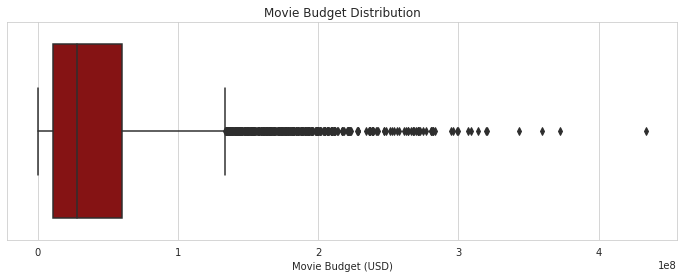

In [31]:
# plot budget quartiles

sns.boxplot(movie_df['budget'], color=mp.colors(2))

plt.xlabel('Movie Budget (USD)')
plt.title('Movie Budget Distribution');

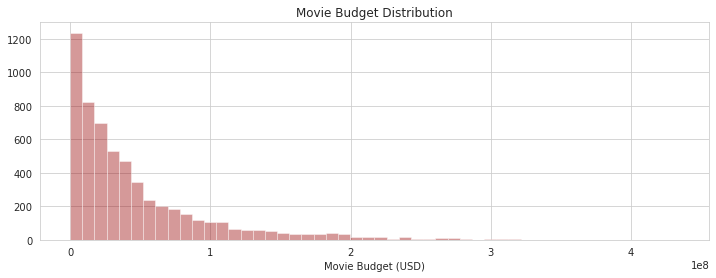

In [32]:
# plot budget distribution

sns.distplot(
    movie_df['budget'], bins=50, color=mp.colors(2), 
    axlabel='Movie Budget (USD)', kde=False)

plt.title('Movie Budget Distribution');

The high budget movies are pulling the distribution far above the median value.<br>
This project has a financial focus.<br>
It is important to include these outliers to see if high budgets are correlated to high revenues.

> **RELEASE DATE**

In [33]:
# observe quartiles and outliers
movie_df['release_date'].describe()

count                    5767
unique                   4172
top       2012-09-07 00:00:00
freq                        7
first     1913-11-24 00:00:00
last      2020-03-16 00:00:00
Name: release_date, dtype: object

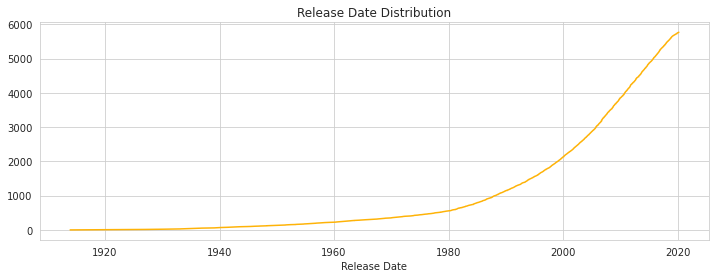

In [34]:
# plot release date distribution

sns.lineplot(
    x=movie_df['release_date'], 
    y=np.linspace(0, len(movie_df['release_date']), 
                  num=len(movie_df['release_date'])), color=mp.colors(3))

plt.xlabel('Release Date')
plt.title('Release Date Distribution');

The release dates are fairly continuous. I'm not concerned with the sparsity of samples from the earliest years.

> **REVENUE**

In [35]:
# observe quartiles and outliers
movie_df['revenue'].describe()

count    5.767000e+03
mean     1.443947e+08
std      2.832705e+08
min      1.238841e+00
25%      1.144973e+07
50%      5.215879e+07
75%      1.581793e+08
max      7.377968e+09
Name: revenue, dtype: float64

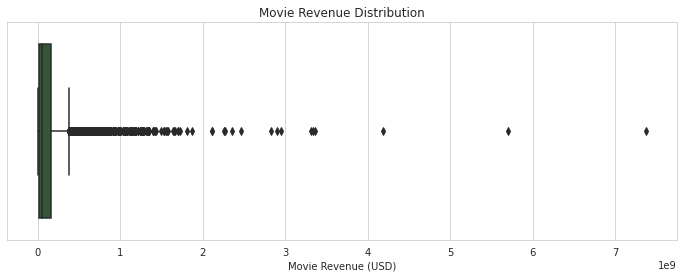

In [36]:
# plot revenue quartiles

sns.boxplot(movie_df['revenue'], color=mp.colors(4), )

plt.xlabel('Movie Revenue (USD)')
plt.title('Movie Revenue Distribution');

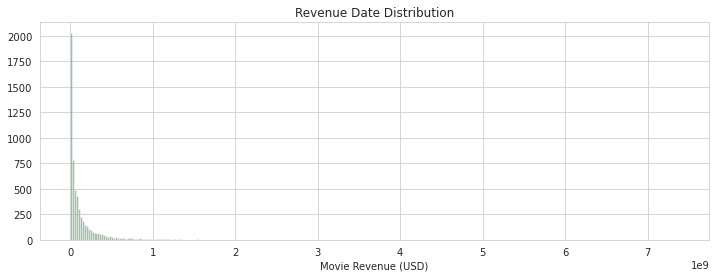

In [37]:
# plot revenue distribution

sns.distplot(movie_df['revenue'], bins=300, color=mp.colors(4), 
             axlabel='Movie Revenue (USD)', kde=False)

plt.title('Revenue Date Distribution');

In [38]:
# observe top revenues
movie_df.sort_values('revenue', ascending=False)[:5]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast
66,7.374714e+07,"[Drama, Romance, War]",770,19.986,1939-12-15,7.377968e+09,233.0,Gone with the Wind,7.9,2207.0,"[{'cast_id': 10, 'character': 'Scarlett O'Hara..."
146,2.989749e+07,"[Animation, Family, Fantasy, Adventure]",12092,28.816,1951-07-28,5.700455e+09,75.0,Alice in Wonderland,7.1,3949.0,"[{'cast_id': 21, 'character': 'Alice (voice)',..."
86,1.342198e+07,"[Animation, Drama, Family]",3170,23.122,1942-08-14,4.183765e+09,70.0,Bambi,7.0,3691.0,"[{'cast_id': 9, 'character': 'Young Bambi (voi..."
55,2.705523e+07,"[Fantasy, Animation, Family]",408,24.408,1938-01-01,3.361411e+09,83.0,Snow White and the Seven Dwarfs,7.1,4976.0,"[{'cast_id': 14, 'character': 'Snow White (voi..."
3844,2.832764e+08,"[Action, Adventure, Fantasy, Science Fiction]",19995,39.970,2009-12-10,3.332341e+09,162.0,Avatar,7.4,21157.0,"[{'cast_id': 242, 'character': 'Jake Sully', '..."


I can believe that these values are true. This is the type of distinction I am trying to capture.

> **PROFIT**

I am interested in observing the profits of movies, after adjusting for inflation.

$$PROFIT = REVENUE - BUDGET$$

In [39]:
# create profit feature
movie_df['profit'] = np.subtract(movie_df['revenue'], movie_df['budget'])
movie_df[['budget', 'revenue', 'profit']].head()

,budget,revenue,profit
0,1.456689e+05,4.600069e+07,4.585502e+07
1,2.581150e+06,2.839265e+08,2.813454e+08
2,1.952082e+08,9.301441e+07,-1.021938e+08
3,2.284204e+07,3.175043e+07,8.908394e+06
4,4.450259e+06,1.780103e+08,1.735601e+08


In [40]:
# observe quartiles and outliers
movie_df['profit'].describe()

count    5.767000e+03
mean     9.929016e+07
std      2.594766e+08
min     -1.831036e+08
25%     -2.044967e+06
50%      2.011734e+07
75%      1.009195e+08
max      7.304220e+09
Name: profit, dtype: float64

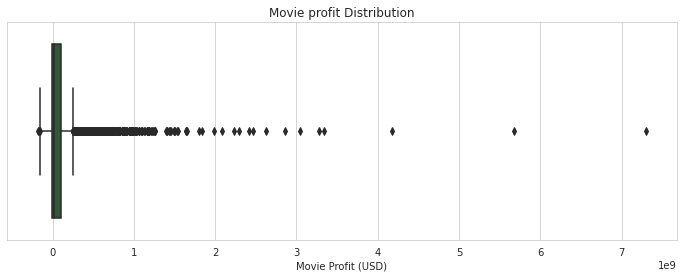

In [41]:
# plot profit quartiles

sns.boxplot(movie_df['profit'], color=mp.colors(4))

plt.xlabel('Movie Profit (USD)')
plt.title('Movie profit Distribution');

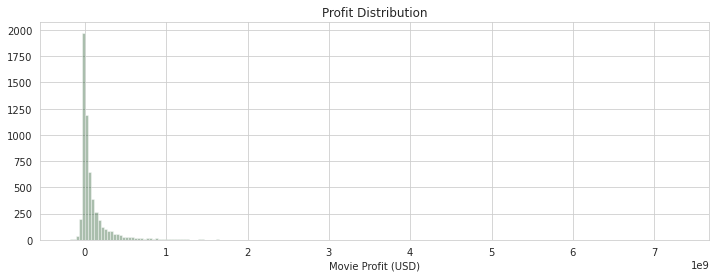

In [42]:
# plot profit distribution

sns.distplot(movie_df['profit'], bins=200, color=mp.colors(4), 
             axlabel='Movie Profit (USD)', kde=False)

plt.title('Profit Distribution');

In [43]:
# observe percentage of movies that made a profit
np.sum(movie_df['profit'] > 0) / len(movie_df['profit']) * 100

69.8109935841859

From what I've read, this is a little optimistic, as it's closer to 50%.<br>
This is a fair estimate, though, considering I am not including any post-release costs.

Now, I will observe the most profitable movies.

In [44]:
# observe movies with largest profits
movie_df.sort_values(
    'profit', ascending=False)[['title', 'profit', 'budget', 'genres']][:13]

,title,profit,budget,genres
66,Gone with the Wind,7.304220e+09,7.374714e+07,"[Drama, Romance, War]"
146,Alice in Wonderland,5.670557e+09,2.989749e+07,"[Animation, Family, Fantasy, Adventure]"
86,Bambi,4.170343e+09,1.342198e+07,"[Animation, Drama, Family]"
55,Snow White and the Seven Dwarfs,3.334356e+09,2.705523e+07,"[Fantasy, Animation, Family]"
487,Star Wars,3.272016e+09,4.708566e+07,"[Adventure, Action, Science Fiction]"
3844,Avatar,3.049064e+09,2.832764e+08,"[Action, Adventure, Fantasy, Science Fiction]"
134,Cinderella,2.863335e+09,3.185249e+07,"[Family, Fantasy, Animation, Romance]"
1858,Titanic,2.629152e+09,3.196471e+08,"[Drama, Romance]"
5674,Avengers: Endgame,2.466329e+09,3.595760e+08,"[Adventure, Science Fiction, Action]"
424,The Exorcist,2.420840e+09,4.469524e+07,[Horror]


After adjusting for inflation, some of the modern blockbusters don't hold up to the classics.

Now, I'll show the movies that really bombed.

In [45]:
# observe movies with largest losses
movie_df.sort_values('profit')[['title', 'profit', 'budget', 'genres']][:13]

,title,profit,budget,genres
4539,The Lone Ranger,-1.831036e+08,2.817656e+08,"[Action, Adventure, Western]"
2748,The Alamo,-1.636285e+08,1.990781e+08,"[Western, History, War]"
5728,The Irishman,-1.589511e+08,1.595607e+08,"[Crime, Drama, History]"
2077,The 13th Warrior,-1.518431e+08,2.471478e+08,"[Adventure, History, Action]"
1655,Cutthroat Island,-1.479456e+08,1.647900e+08,"[Action, Adventure]"
367,Waterloo,-1.437845e+08,1.637786e+08,"[History, Action, Drama, War]"
2491,The Adventures of Pluto Nash,-1.326943e+08,1.428417e+08,"[Action, Comedy, Science Fiction]"
4083,Mars Needs Moms,-1.282186e+08,1.732571e+08,"[Adventure, Animation, Family]"
588,Heaven's Gate,-1.223123e+08,1.328311e+08,"[Drama, Western]"
284,The Fall of the Roman Empire,-1.190336e+08,1.587115e+08,"[Drama, History, War]"


Many of these movies have big name actors.<br>
Apparently, it takes more than actor recognition to guarentee ticket sales.

> **RUNTIME**

In [46]:
# observe quartiles and outliers
movie_df['runtime'].describe()

count    5767.000000
mean      108.537368
std        20.417757
min        70.000000
25%        95.000000
50%       105.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

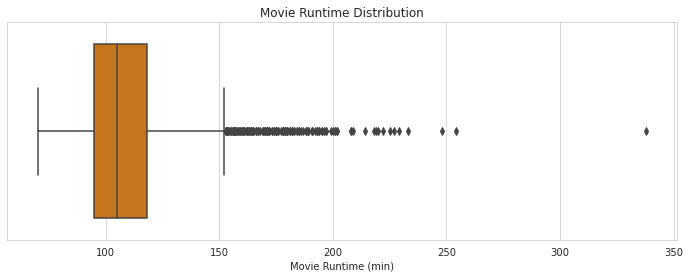

In [47]:
# plot runtime quartiles

sns.boxplot(movie_df['runtime'], color=mp.colors(5))

plt.xlabel('Movie Runtime (min)')
plt.title('Movie Runtime Distribution');

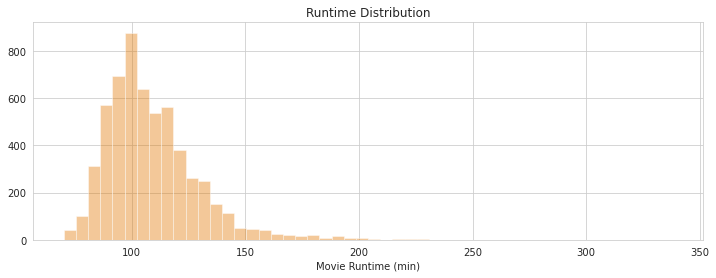

In [48]:
# plot runtime distribution

sns.distplot(movie_df['runtime'], bins=50, color=mp.colors(5), 
             axlabel='Movie Runtime (min)', kde=False)

plt.title('Runtime Distribution');

In [49]:
# observe the long running movies
movie_df.sort_values('runtime', ascending=False)[:5]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast,profit
4001,2.124296e+07,"[Crime, Drama, Thriller, History]",43434,8.000,2010-10-11,1.028253e+06,338.0,Carlos,7.0,104.0,"[{'cast_id': 4, 'character': 'Ilich Ramírez Sá...",-2.021471e+07
1447,4.428878e+07,"[Drama, History, War]",10655,8.792,1993-10-08,2.249870e+07,254.0,Gettysburg,6.9,158.0,"[{'cast_id': 1, 'character': 'Col. Joshua Cham...",-2.179008e+07
275,2.624591e+08,"[Drama, History, Romance]",8095,14.965,1963-06-12,5.988943e+08,248.0,Cleopatra,7.0,339.0,"[{'cast_id': 2, 'character': 'Cleopatra', 'cre...",3.364352e+08
66,7.374714e+07,"[Drama, Romance, War]",770,19.986,1939-12-15,7.377968e+09,233.0,Gone with the Wind,7.9,2207.0,"[{'cast_id': 10, 'character': 'Scarlett O'Hara...",7.304220e+09
756,4.992553e+07,"[Drama, Crime]",311,22.262,1984-05-23,1.323027e+07,229.0,Once Upon a Time in America,8.4,2897.0,"[{'cast_id': 3, 'character': 'David 'Noodles' ...",-3.669527e+07


The movie Carlos is a significant outlier.<br>
It could be considered a tv mini-series.<br>
I will remove it.

In [50]:
# drop tv movie
movie_df.drop(index=movie_df[movie_df['runtime'] > 300].index, inplace=True)

In [51]:
# reset the index
movie_df.reset_index(drop=True, inplace=True)
movie_df.iloc[np.r_[0:2, -2:0]]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast,profit
0,1.456689e+05,"[Drama, Crime]",96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,"[{'cast_id': 10, 'character': 'Mary Barton', '...",4.585502e+07
1,2.581150e+06,"[Drama, History, War]",618,11.115,1915-02-08,2.839265e+08,193.0,The Birth of a Nation,6.3,277.0,"[{'cast_id': 16, 'character': 'Elsie Stoneman'...",2.813454e+08
5764,1.400000e+07,"[Action, Thriller, Horror]",514847,37.214,2020-03-11,6.512500e+06,90.0,The Hunt,6.8,607.0,"[{'cast_id': 29, 'character': 'Crystal', 'cred...",-7.487500e+06
5765,2.700000e+07,"[Mystery, Action, Crime, Drama, Thriller]",686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,"[{'cast_id': 2, 'character': 'Sebastian Spade'...",2.132000e+07


> **MOVIE ID & TITLE**

The TMDb IDs and titles are being kept to reference movies.<br>
They will help with heuristic model evaluation based on my knowledge of movies and information from the internet.

In [52]:
# verifying unique IDs
movie_df['movie_id'].is_unique

True

While I wouldn't expect to have unique movie titles, it is good to have unique IDs.

> **VOTE AVERAGE**

In [53]:
# observe quartiles and outliers
movie_df['vote_average'].describe()

count    5766.000000
mean        6.413510
std         0.976932
min         1.000000
25%         5.900000
50%         6.400000
75%         7.000000
max        10.000000
Name: vote_average, dtype: float64

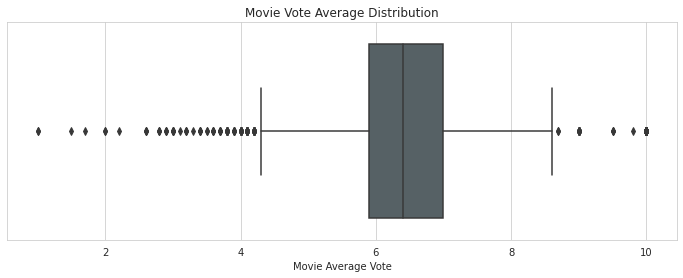

In [54]:
# plot vote average quartiles

sns.boxplot(movie_df['vote_average'], color=mp.colors(6))

plt.xlabel('Movie Average Vote')
plt.title('Movie Vote Average Distribution');

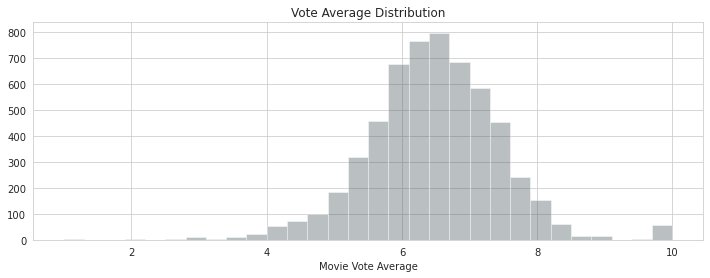

In [55]:
# plot vote average distribution

sns.distplot(movie_df['vote_average'], bins=30, color=mp.colors(6), 
             axlabel='Movie Vote Average', kde=False)

plt.title('Vote Average Distribution');

The vote average leans toward a favorable rating.

In [56]:
# checking on the outliers
movie_df.loc[movie_df['vote_average'] == 10]['vote_count'].value_counts()

1.0    55
2.0     1
Name: vote_count, dtype: int64

The movies with averages of 10 have no more than 2 votes each.<br>
This feature looks clean.

> **VOTE COUNT**

In [57]:
# observe quartiles and outliers
movie_df['vote_count'].describe()

count     5766.000000
mean      1551.571453
std       2559.576794
min          1.000000
25%        156.000000
50%        597.000000
75%       1772.000000
max      25603.000000
Name: vote_count, dtype: float64

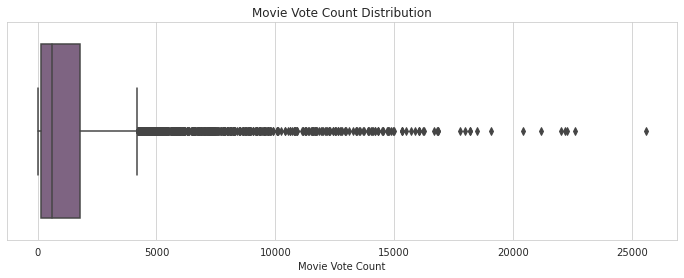

In [58]:
# plot vote count quartiles

sns.boxplot(movie_df['vote_count'], color=mp.colors(1))

plt.xlabel('Movie Vote Count')
plt.title('Movie Vote Count Distribution');

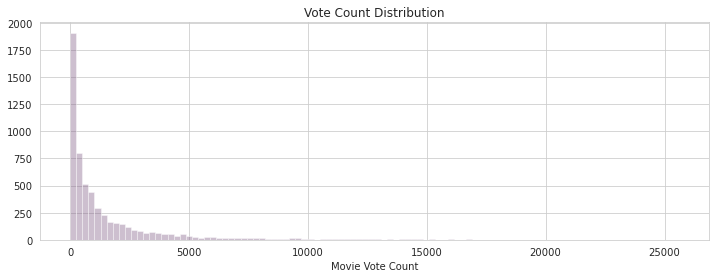

In [59]:
# plot vote count distribution

sns.distplot(movie_df['vote_count'], bins=100, color=mp.colors(1), 
             axlabel='Movie Vote Count', kde=False)

plt.title('Vote Count Distribution');

In [60]:
# observe high vote count outlier
movie_df.loc[movie_df['vote_count'] == movie_df['vote_count'].max()]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast,profit
3942,1.894326e+08,"[Action, Science Fiction, Adventure]",27205,63.83,2010-07-15,9.773928e+08,148.0,Inception,8.3,25603.0,"[{'cast_id': 1, 'character': 'Dom Cobb', 'cred...",7.879602e+08


That looks right to me.

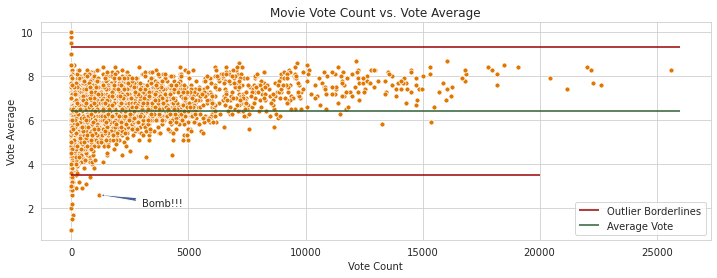

In [61]:
# plot vote count vs. vote average

sns.scatterplot(data=movie_df, x='vote_count', y='vote_average', 
                color=mp.colors(5), s=25)

plt.hlines(y=(np.mean(movie_df['vote_average']) + np.std(movie_df['vote_average']) * 3), 
           xmin=0, xmax=26000, label='Outlier Borderlines', color=mp.colors(2))
plt.hlines(y=np.mean(movie_df['vote_average']), 
           xmin=0, xmax=26000, label='Average Vote', color=mp.colors(4))
plt.hlines(y=(np.mean(movie_df['vote_average']) - np.std(movie_df['vote_average']) * 3), 
           xmin=0, xmax=20000, color=mp.colors(2))

plt.annotate('Bomb!!!', xy=(1180, 2.6), xytext=(3000, 2.1), 
             arrowprops=dict(arrowstyle='fancy', connectionstyle='arc3'))

plt.xlabel('Vote Count')
plt.ylabel('Vote Average')

plt.legend(loc=4)

plt.title('Movie Vote Count vs. Vote Average');

Most of the movies are near the average vote for all movies.<br>
Movies far away from the average overall rating have few votes, except one.<br>
I will find out which movie has over 1,000 votes, but still had an average score below 3.

In [62]:
# find bomb of gereral consent
movie_df[(movie_df['vote_count'] > 1000) & (movie_df['vote_average'] < 3)]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,cast,profit
3687,1.213465e+08,"[Action, Adventure, Fantasy, Science Fiction, ...",14164,14.892,2009-03-12,6.977147e+07,85.0,Dragonball Evolution,2.6,1180.0,"[{'cast_id': 1, 'character': 'Goku', 'credit_i...",-5.157507e+07


As one critic put it, "Dragonball has been perfectly designed to blow the mind of a 10-year-old boy." 'nuff said

> **GENRES**

The 19 unique TMDb genre categories are grouped together into lists of genre combinations.<br>
One possible way to observe these combinations is to treat them as unique genres, themselves.<br>
This significantly increases the dimensionality of the data.<br>
I'll investigate this possibility.

I want to get a count of unique genre combinations.<br>
I needed to convert the column of lists to a Series of tuples to avoid an unhashable type error.

In [63]:
# put unique genres lists into Series
unique_genres_count = movie_df['genres'].apply(tuple).value_counts()

In [64]:
# observe Series
unique_genres_count

(Drama,)                                                         358
(Comedy,)                                                        310
(Drama, Romance)                                                 194
(Comedy, Romance)                                                152
(Comedy, Drama)                                                  152
                                                                ... 
(Action, Adventure, Comedy, Family, Fantasy, Science Fiction)      1
(Action, Drama, War, Romance, Thriller)                            1
(Action, Mystery, Thriller, Drama)                                 1
(Drama, Western, History)                                          1
(Science Fiction, Comedy, Horror)                                  1
Name: genres, Length: 1392, dtype: int64

Note that the genres are the keys of this Series.

In [65]:
# count unique combinations of genres
len(unique_genres_count)

1392

I want to make the unique genre combinations features, but there are a lot of them.<br>
I will look at their distribution.

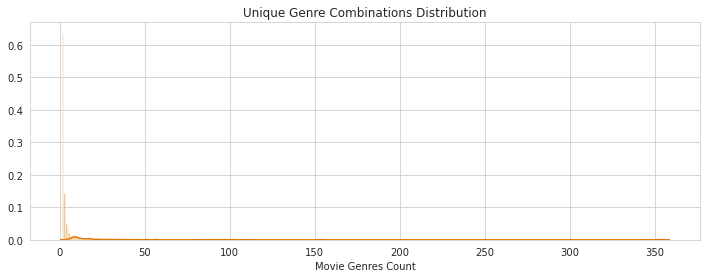

In [66]:
# plot genres distribution

sns.distplot(
    unique_genres_count, bins=360, color=mp.colors(5), axlabel='Movie Genres Count')

plt.title('Unique Genre Combinations Distribution');

I want to isolate where the distribution flattens out to bin unique genre combinations with few entries together.

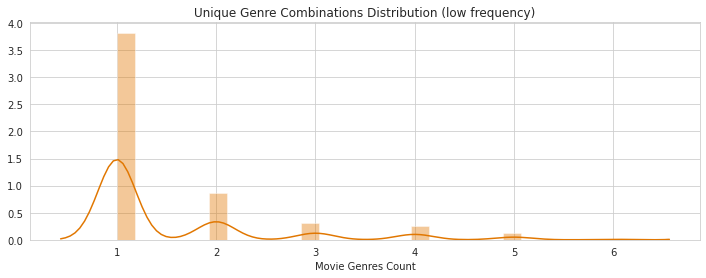

In [67]:
# plot genres distribution for low count of movies

sns.distplot(unique_genres_count[150:], color=mp.colors(5), axlabel='Movie Genres Count')

plt.title('Unique Genre Combinations Distribution (low frequency)');

In [68]:
# look for where genre combinations drop to individual movies
unique_genres_count[510:]

(Mystery, Thriller, Crime)                                       2
(Adventure, Fantasy, Mystery)                                    2
(Comedy, Family, Music, Romance)                                 2
(Action, Comedy, Horror)                                         1
(Horror, Mystery, Thriller, Comedy)                              1
                                                                ..
(Action, Adventure, Comedy, Family, Fantasy, Science Fiction)    1
(Action, Drama, War, Romance, Thriller)                          1
(Action, Mystery, Thriller, Drama)                               1
(Drama, Western, History)                                        1
(Science Fiction, Comedy, Horror)                                1
Name: genres, Length: 882, dtype: int64

The counts drop down to one observation per genre combination at index 513.

In [69]:
# observe percentage of movies that are the only observation of their genre combination
unique_genres_count[513:].sum() / len(movie_df['genres']) * 100

15.244536940686784

Binning all of these movies together would reduce the dataset by 15%.<br>
I would have 512 unique move genre combinations plus one miscellaneous genre.

In [70]:
# isolate movies that are the only observation of their genre combination
# put them in nested list
one_movie_genres = [list(x) for x in list(
    unique_genres_count[unique_genres_count == 1].index)]
one_movie_genres[:3]

[['Action', 'Comedy', 'Horror'],
 ['Horror', 'Mystery', 'Thriller', 'Comedy'],
 ['Comedy', 'Adventure', 'Family', 'Fantasy']]

In [71]:
# count the number of movies that will be grouped together
len(one_movie_genres)

879

This is how many observations would lose their unique effect by binning them together.<br>
I am not ready to drop these movies, quite yet.

A second way to use the genre combination lists is to divide them into the general TMDb genres that they contain.<br>
If a movie has elements of more than one base genre, it will be counted as belonging to both groups.<br>
I can aggregate this information by actor to get counts of base genres for all their movies.

In [72]:
# instantiate MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [73]:
# binarize genres labels
binary_genres = mlb.fit_transform(movie_df['genres'])
binary_genres

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

In [74]:
# observe new column names
mlb.classes_

array(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western'], dtype=object)

In [75]:
# create a DataFrame from the binarizeded array
binary_genres_df = pd.DataFrame(binary_genres, columns=mlb.classes_)
binary_genres_df.iloc[np.r_[0:3, -3:0]]

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
5763,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5764,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
5765,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0


In [76]:
# observe memory size of genres in original form
movie_df['genres'].memory_usage()

46256

In [77]:
# observe memory size of genres in new form
binary_genres_df.memory_usage().sum()

876560

In [78]:
# join two DataFrames
movie_df = movie_df.join(binary_genres_df)
movie_df.iloc[np.r_[0:2, -2:0]]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1.456689e+05,"[Drama, Crime]",96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,...,0,0,0,0,0,0,0,0,0,0
1,2.581150e+06,"[Drama, History, War]",618,11.115,1915-02-08,2.839265e+08,193.0,The Birth of a Nation,6.3,277.0,...,1,0,0,0,0,0,0,0,1,0
5764,1.400000e+07,"[Action, Thriller, Horror]",514847,37.214,2020-03-11,6.512500e+06,90.0,The Hunt,6.8,607.0,...,0,1,0,0,0,0,0,1,0,0
5765,2.700000e+07,"[Mystery, Action, Crime, Drama, Thriller]",686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,0,0,1,0,0,0,1,0,0


In [79]:
# make column names lowercase and remove white spaces
movie_df.columns = movie_df.columns.str.lower().str.replace(' ', '_')
movie_df.columns

Index(['budget', 'genres', 'movie_id', 'popularity', 'release_date', 'revenue',
       'runtime', 'title', 'vote_average', 'vote_count', 'cast', 'profit',
       'action', 'adventure', 'animation', 'comedy', 'crime', 'documentary',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music', 'mystery',
       'romance', 'science_fiction', 'tv_movie', 'thriller', 'war', 'western'],
      dtype='object')

I am going to remove the documentary and tv movies from the dataset, as they are out of scope for this project.

In [80]:
movie_df.drop(
    index=movie_df[(movie_df['documentary'] > 0) 
                   | (movie_df['tv_movie'] > 0)].index, inplace=True)

> **CAST**

In [81]:
# observe general form of cast lists
movie_df['cast']

0       [{'cast_id': 10, 'character': 'Mary Barton', '...
1       [{'cast_id': 16, 'character': 'Elsie Stoneman'...
2       [{'cast_id': 23, 'character': 'The Woman Who R...
3       [{'cast_id': 3, 'character': 'Anitia', 'credit...
4       [{'cast_id': 1, 'character': 'Prince Daaker's ...
                              ...                        
5761    [{'cast_id': 0, 'character': 'Himself', 'credi...
5762    [{'cast_id': 7, 'character': 'Cecilia Kass', '...
5763    [{'cast_id': 51, 'character': 'Ray Garrison / ...
5764    [{'cast_id': 29, 'character': 'Crystal', 'cred...
5765    [{'cast_id': 2, 'character': 'Sebastian Spade'...
Name: cast, Length: 5684, dtype: object

In [82]:
# observe top five billing from one movie
movie_df['cast'][5501][:5]

[{'cast_id': 6,
  'character': 'Davis Okoye',
  'credit_id': '5882c5e6925141044c003768',
  'gender': 2,
  'id': 18918,
  'name': 'Dwayne Johnson',
  'order': 0,
  'profile_path': '/gNDWZkr6tST1Z5xcOCUwthY78CN.jpg'},
 {'cast_id': 7,
  'character': 'Dr. Kate Caldwell',
  'credit_id': '5888f45e9251411bd500bb34',
  'gender': 1,
  'id': 2038,
  'name': 'Naomie Harris',
  'order': 1,
  'profile_path': '/41TVAcYqKKF7PGf3x7QfaLvkLSW.jpg'},
 {'cast_id': 14,
  'character': 'Claire Wyden',
  'credit_id': '58cab7d6c3a368715b0008ec',
  'gender': 1,
  'id': 50463,
  'name': 'Malin Åkerman',
  'order': 2,
  'profile_path': '/u38qRcCAiO3SZdFKJKx3fncDyef.jpg'},
 {'cast_id': 15,
  'character': 'Agent Russell',
  'credit_id': '5a0e2719c3a368628c002c92',
  'gender': 2,
  'id': 47296,
  'name': 'Jeffrey Dean Morgan',
  'order': 3,
  'profile_path': '/d7K3JNkf0LMdrOWJRZV81jiVa8i.jpg'},
 {'cast_id': 10,
  'character': 'Brett Wyden',
  'credit_id': '58a3aeab92514157a50011d6',
  'gender': 2,
  'id': 496470,
  

The lists hold one dict for each actor. The number of actors varies between movies.

In [83]:
# check for duplicate rows
movie_df.drop(['genres', 'cast'], axis=1).duplicated().sum()

0

In [84]:
# create DataFarme with cast in their own rows and duplicate indices which match movies
cast_members_df = movie_df.drop(
    columns=['cast']).join(
    movie_df['cast'].explode().to_frame())
cast_members_df.iloc[np.r_[0:3, -3:0]]

,budget,genres,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western,cast
0,1.456689e+05,"[Drama, Crime]",96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,...,0,0,0,0,0,0,0,0,0,"{'cast_id': 10, 'character': 'Mary Barton', 'c..."
0,1.456689e+05,"[Drama, Crime]",96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,...,0,0,0,0,0,0,0,0,0,"{'cast_id': 3, 'character': 'Lorna Barton', 'c..."
0,1.456689e+05,"[Drama, Crime]",96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,...,0,0,0,0,0,0,0,0,0,"{'cast_id': 4, 'character': 'Mary's father', '..."
5765,2.700000e+07,"[Mystery, Action, Crime, Drama, Thriller]",686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,0,1,0,0,0,1,0,0,"{'cast_id': 15, 'character': 'Himself', 'credi..."
5765,2.700000e+07,"[Mystery, Action, Crime, Drama, Thriller]",686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,0,1,0,0,0,1,0,0,"{'cast_id': 13, 'character': 'Sailor #1', 'cre..."
5765,2.700000e+07,"[Mystery, Action, Crime, Drama, Thriller]",686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,0,1,0,0,0,1,0,0,"{'cast_id': 14, 'character': 'Sailor #2', 'cre..."


In [85]:
# expand dicts of cast column as their own DataFrame
cast_normalized_df = pd.json_normalize(cast_members_df['cast'])
cast_normalized_df

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,10,Mary Barton,5e2b57a9532acb0019515e07,1,105945,Jane Gail,0,/pFmtBjoHCK1JRhBNfTeyRcLSYSW.jpg
1,3,Lorna Barton,52fe49a29251416c750ce52b,1,1070243,Ethel Grandin,1,/bPGgdb4cGLjxH78wrXnAUUKx3q7.jpg
2,4,Mary's father,5bb6ff690e0a2633a701f416,0,1405084,William H. Turner,2,/6uGbk83pJpeUgQf5XTPPkVikIF6.jpg
3,5,Burke,5bb6ffec0e0a26339702019f,2,61101,Matt Moore,3,/oj7AI3ecCjOXbysuluioNsEUrhq.jpg
4,6,Alice Trubus,5bb70008c3a368151002400f,0,2142031,Irene Wallace,4,None
...,...,...,...,...,...,...,...,...
170286,3,Quentin Sharpe,5e7ce47bd861af2f0ab80f00,2,2550091,Charlie R. Knibb,1,/wbWEKnnTxaIerDO8T4fpZ0UpNbt.jpg
170287,1,Sarah Kelly,5e7ce405109dec1ebb024e64,1,2550092,Emma Coe,2,/mTBfqpqCjs7FVZVCtGKW6QbHfrq.jpg
170288,15,Himself,5e7ce699ab1bc75cb1c2a410,2,2562896,Bobby Seagull,3,/6ZDIf5Sqk0CP9kTnf6gguduUG6S.jpg
170289,13,Sailor #1,5e7ce67bd861af312ab84612,0,2562894,Patrick Knibb,4,/kx0crEX2iuXUfosqvwXj4TeseZl.jpg


In [86]:
# rename actor id to avoid confusion
cast_normalized_df.rename(columns={'id': 'person_id'}, inplace=True)

In [87]:
# drop columns not needed
cast_normalized_df.drop(
    ['cast_id', 'character', 'credit_id', 'gender', 'name', 'profile_path'], 
    axis=1, inplace=True)
cast_normalized_df

,person_id,order
0,105945,0
1,1070243,1
2,1405084,2
3,61101,3
4,2142031,4
...,...,...
170286,2550091,1
170287,2550092,2
170288,2562896,3
170289,2562894,4


The order feature represents the billing order for each movie with top billing having a value of zero.

In [88]:
# reset the index to merge on normalized DataFrame
cast_members_df.reset_index(drop=True, inplace=True)

In [89]:
# observe features of new movie DataFrame
cast_members_df.columns

Index(['budget', 'genres', 'movie_id', 'popularity', 'release_date', 'revenue',
       'runtime', 'title', 'vote_average', 'vote_count', 'profit', 'action',
       'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama',
       'family', 'fantasy', 'history', 'horror', 'music', 'mystery', 'romance',
       'science_fiction', 'tv_movie', 'thriller', 'war', 'western', 'cast'],
      dtype='object')

In [90]:
# drop columns not needed
cast_members_df.drop(
    ['genres', 'cast'], 
    axis=1, inplace=True)
cast_members_df.iloc[np.r_[0:2, -2:0]]

,budget,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,profit,...,history,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western
0,1.456689e+05,96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,4.585502e+07,...,0,0,0,0,0,0,0,0,0,0
1,1.456689e+05,96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,4.585502e+07,...,0,0,0,0,0,0,0,0,0,0
170289,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,2.132000e+07,...,0,0,0,1,0,0,0,1,0,0
170290,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,2.132000e+07,...,0,0,0,1,0,0,0,1,0,0


In [91]:
# join DataFrames on index
cast_members_df = cast_members_df.join(cast_normalized_df)
cast_members_df

,budget,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,profit,...,music,mystery,romance,science_fiction,tv_movie,thriller,war,western,person_id,order
0,1.456689e+05,96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,4.585502e+07,...,0,0,0,0,0,0,0,0,105945,0
1,1.456689e+05,96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,4.585502e+07,...,0,0,0,0,0,0,0,0,1070243,1
2,1.456689e+05,96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,4.585502e+07,...,0,0,0,0,0,0,0,0,1405084,2
3,1.456689e+05,96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,4.585502e+07,...,0,0,0,0,0,0,0,0,61101,3
4,1.456689e+05,96128,1.646,1913-11-24,4.600069e+07,88.0,Traffic in Souls,5.6,12.0,4.585502e+07,...,0,0,0,0,0,0,0,0,2142031,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170286,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,2.132000e+07,...,0,1,0,0,0,1,0,0,2550091,1
170287,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,2.132000e+07,...,0,1,0,0,0,1,0,0,2550092,2
170288,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,2.132000e+07,...,0,1,0,0,0,1,0,0,2562896,3
170289,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,2.132000e+07,...,0,1,0,0,0,1,0,0,2562894,4


In [92]:
# check for duplicate actors in a movie
cast_members_df.duplicated(subset=['person_id', 'movie_id']).sum()

204

I did some sleuthing on this. There are people with double credits in some movies. I will remove the duplicates.

In [93]:
# drop double credits
cast_members_df.drop_duplicates(subset=['person_id', 'movie_id'], inplace=True)

Now, there are a lot of actors in this dataset.<br>
Many of them are far down in the billing order.<br>
I'll drop actors below 8 in the billing list to filter out the numerous bit role actors.

In [94]:
# drop actors past 8 in billing order
cast_members_df = cast_members_df.loc[
    cast_members_df.loc[cast_members_df['order'] < 9].index]

In [95]:
# bring person ID to front of DataFrame and sort by person
cols = list(cast_members_df)
cols.insert(0, cols.pop(cols.index('person_id')))
cast_members_df = cast_members_df.loc[:, cols].sort_values('person_id')
cast_members_df

,person_id,budget,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,horror,music,mystery,romance,science_fiction,tv_movie,thriller,war,western,order
16673,2,1.419948e+07,16121,9.930,1980-05-28,2.273880e+07,113.0,The Big Red One,6.8,150.0,...,0,0,0,0,0,0,0,1,0,1
14532,2,4.708566e+07,11,90.645,1977-05-25,3.319102e+09,121.0,Star Wars,8.2,13502.0,...,0,0,0,0,1,0,0,0,0,0
40414,2,1.062202e+07,14919,12.348,1993-12-25,9.944670e+06,76.0,Batman: Mask of the Phantasm,7.5,535.0,...,0,0,1,0,0,0,1,0,0,1
20308,2,8.417359e+07,1892,33.089,1983-05-25,1.490146e+09,135.0,Return of the Jedi,8.0,9505.0,...,0,0,0,0,1,0,0,0,0,0
14391,2,5.240914e+06,16220,11.288,1977-02-09,3.930685e+07,80.0,Wizards,6.5,97.0,...,0,0,0,0,1,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92929,2622415,1.853067e+06,1961,8.363,2007-10-01,2.138020e+05,86.0,My Name Is Bruce,5.9,183.0,...,1,0,0,0,0,0,0,0,0,2
92930,2622417,1.853067e+06,1961,8.363,2007-10-01,2.138020e+05,86.0,My Name Is Bruce,5.9,183.0,...,1,0,0,0,0,0,0,0,0,3
92931,2622418,1.853067e+06,1961,8.363,2007-10-01,2.138020e+05,86.0,My Name Is Bruce,5.9,183.0,...,1,0,0,0,0,0,0,0,0,4
92933,2622422,1.853067e+06,1961,8.363,2007-10-01,2.138020e+05,86.0,My Name Is Bruce,5.9,183.0,...,1,0,0,0,0,0,0,0,0,6


The dataset below is from the actor data.<br>
There's just a couple of features from this to tack onto the monster dataset above.

> **PERSON DATASET**

In [96]:
# read in person dataset
person_df = pd.read_json('tmdb_person_clean.json')

In [97]:
# convert birthdays to datetime objects and remove timezone-aware index
person_df['birthday'] = pd.to_datetime(person_df['birthday']).dt.tz_localize(None)
person_df.head()

,birthday,known_for_department,id,name,gender,biography,popularity,place_of_birth,imdb_id
0,1944-05-14,Directing,1,George Lucas,2.0,"George Walton Lucas Jr. (born May 14, 1944) is...",6.761,"Modesto, California, USA",nm0000184
1,1951-09-25,Acting,2,Mark Hamill,2.0,"Mark Richard Hamill (born September 25, 1951) ...",10.497,"Concord, California, USA",nm0000434
2,1942-07-13,Acting,3,Harrison Ford,2.0,Legendary Hollywood Icon Harrison Ford was bor...,20.349,"Chicago, Illinois, USA",nm0000148
3,1956-10-21,Acting,4,Carrie Fisher,1.0,Carrie Frances Fisher (21 October 1956 - 27 De...,7.228,"Beverly Hills, Los Angeles, California, USA",nm0000402
4,1913-05-26,Acting,5,Peter Cushing,2.0,"Peter Wilton Cushing, OBE (26 May 1913 – 11 A...",3.902,"Kenley, Surrey, England, UK",nm0001088


In [98]:
# count the actors
np.sum(person_df['known_for_department'] == 'Acting')

941186

In [99]:
# remove non-actors
person_df = person_df[person_df['known_for_department'] == 'Acting']
person_df.iloc[np.r_[0:2, -2:0]]

,birthday,known_for_department,id,name,gender,biography,popularity,place_of_birth,imdb_id
1,1951-09-25,Acting,2,Mark Hamill,2.0,"Mark Richard Hamill (born September 25, 1951) ...",10.497,"Concord, California, USA",nm0000434
2,1942-07-13,Acting,3,Harrison Ford,2.0,Legendary Hollywood Icon Harrison Ford was bor...,20.349,"Chicago, Illinois, USA",nm0000148
2699993,NaT,Acting,2618069,Gérard Krause,NaN,,0.600,None,
2699996,NaT,Acting,2618072,Emmanuel Camacho,NaN,,0.600,None,


In [100]:
# drop columns that will not be used
person_df.drop(
    ['known_for_department', 'biography', 'popularity', 'imdb_id'], 
    axis=1, inplace=True)
person_df.iloc[np.r_[0:2, -2:0]]

,birthday,id,name,gender,place_of_birth
1,1951-09-25,2,Mark Hamill,2.0,"Concord, California, USA"
2,1942-07-13,3,Harrison Ford,2.0,"Chicago, Illinois, USA"
2699993,NaT,2618069,Gérard Krause,NaN,None
2699996,NaT,2618072,Emmanuel Camacho,NaN,None


In [101]:
# rename actor id to avoid confusion
person_df.rename(columns={'id': 'person_id'}, inplace=True)
person_df.columns

Index(['birthday', 'person_id', 'name', 'gender', 'place_of_birth'], dtype='object')

In [102]:
# observe person DataFrame
person_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941186 entries, 1 to 2699996
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   birthday        117030 non-null  datetime64[ns]
 1   person_id       941186 non-null  int64         
 2   name            941186 non-null  object        
 3   gender          186717 non-null  float64       
 4   place_of_birth  98522 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 43.1+ MB


In [103]:
# drop rows with missing values
person_df.dropna(inplace=True)
person_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83654 entries, 1 to 2699989
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   birthday        83654 non-null  datetime64[ns]
 1   person_id       83654 non-null  int64         
 2   name            83654 non-null  object        
 3   gender          83654 non-null  float64       
 4   place_of_birth  83654 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 3.8+ MB


In [104]:
# reset the index
person_df.reset_index(drop=True, inplace=True)
person_df.iloc[np.r_[0:3, -3:0]]

,birthday,person_id,name,gender,place_of_birth
0,1951-09-25,2,Mark Hamill,2.0,"Concord, California, USA"
1,1942-07-13,3,Harrison Ford,2.0,"Chicago, Illinois, USA"
2,1956-10-21,4,Carrie Fisher,1.0,"Beverly Hills, Los Angeles, California, USA"
83651,1979-10-11,2617783,Larusso,1.0,Paris
83652,1992-06-10,2617846,Tejasswi Prakash,1.0,"Jebbah, Saudi Arabia"
83653,1998-08-31,2618065,Saanjh Su Kumar,1.0,São Paulo


> **BIRTHDAY**

In [105]:
# observe ends of range of values
person_df.sort_values('birthday').iloc[np.r_[0:7, -7:0]]

,birthday,person_id,name,gender,place_of_birth
24392,1756-01-15,123029,Jan Edgar Fjell,2.0,"Fredrikstad, Østfold, Norway"
17013,1816-10-16,80645,Joseph Whitley,2.0,"Wakefield, Yorkshire, England, UK"
49942,1818-05-05,1249715,Karl Marx,2.0,"Trier, Germany"
42758,1819-05-24,1127369,Queen Victoria,1.0,"London, England, UK"
64030,1835-11-25,1672783,Andrew Carnegie,2.0,"Dunfermline, Fife, Scotland, UK"
42678,1838-10-27,1124430,John Davis Long,2.0,"Buckfield, Maine, USA"
79005,1839-07-08,2349331,John D. Rockefeller,2.0,"Richford, New York, USA"
77190,2019-04-14,2294474,Vincent Munier,2.0,"Épinal, France"
81491,2019-05-06,2508110,Archie Mountbatten-Windsor,2.0,"London, England, UK"
80554,2019-05-10,2439826,Psalm West,2.0,"Los Angeles, California, USA"


The birthdays are extreme in range.<br>
Jan Edgar Fjell was born in 1956. Miguel Iza was born in 1968. Prince Henry's son is on the list, too.<br>
I will keep these for now, as many of them will not have matches in the movie credits data.<br>
I can sort it out later, if necessary.

> **GENDER**

I will encoe the genders to male actors as 0 and female actors as 1.

In [106]:
# binary encode gender
person_df['gender'] = person_df['gender'].replace(2, 0)
person_df.iloc[np.r_[0:3, -3:0]]

,birthday,person_id,name,gender,place_of_birth
0,1951-09-25,2,Mark Hamill,0.0,"Concord, California, USA"
1,1942-07-13,3,Harrison Ford,0.0,"Chicago, Illinois, USA"
2,1956-10-21,4,Carrie Fisher,1.0,"Beverly Hills, Los Angeles, California, USA"
83651,1979-10-11,2617783,Larusso,1.0,Paris
83652,1992-06-10,2617846,Tejasswi Prakash,1.0,"Jebbah, Saudi Arabia"
83653,1998-08-31,2618065,Saanjh Su Kumar,1.0,São Paulo


In [107]:
# convert data type for performance
person_df['gender'] = person_df['gender'].astype(int)

In [108]:
# observe gender quartiles
person_df['gender'].describe()

count    83654.000000
mean         0.413429
std          0.492451
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

The men play almost 59% of the roles.

> **PLACE OF BIRTH**

I will extract some easy information out of the place of birth data.<br>
To do this, I am going to classify actors as either born American or not.

In [109]:
# convert places of birth in USA to 1
person_df.loc[person_df.loc[person_df['place_of_birth'].apply(
    lambda x: x.split(', ')[-1] == 'USA')].index, 'place_of_birth'] = 1

In [110]:
# convert all other places of birth to 0
person_df.loc[person_df.loc[person_df['place_of_birth'].apply(lambda x: x != 1)].index, 'place_of_birth'] = 0

In [111]:
# rename feature
person_df.rename(columns={'place_of_birth': 'usa'}, inplace=True)
person_df.iloc[np.r_[0:3, -3:0]]

,birthday,person_id,name,gender,usa
0,1951-09-25,2,Mark Hamill,0,1
1,1942-07-13,3,Harrison Ford,0,1
2,1956-10-21,4,Carrie Fisher,1,1
83651,1979-10-11,2617783,Larusso,1,0
83652,1992-06-10,2617846,Tejasswi Prakash,1,0
83653,1998-08-31,2618065,Saanjh Su Kumar,1,0


> **MERGE DATA**

First, I need to remove duplicate actors.

In [112]:
# verify actor ID is unique
person_df['person_id'].is_unique

False

In [113]:
# count duplicates
person_df['person_id'].duplicated().sum()

934

In [114]:
# drop duplicates
person_df['person_id'].drop_duplicates(inplace=True)

In [115]:
# trust but verify
person_df['person_id'].duplicated().sum()

0

Finally, I can bring the 2 datasets toogether.

In [116]:
# merge DataSets
actor_df = pd.merge(cast_members_df, person_df)
actor_df.iloc[np.r_[0:3, -3:0]]

,person_id,budget,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,science_fiction,tv_movie,thriller,war,western,order,birthday,name,gender,usa
0,2,1.419948e+07,16121,9.930,1980-05-28,2.273880e+07,113.0,The Big Red One,6.8,150.0,...,0,0,0,1,0,1,1951-09-25,Mark Hamill,0,1
1,2,4.708566e+07,11,90.645,1977-05-25,3.319102e+09,121.0,Star Wars,8.2,13502.0,...,1,0,0,0,0,0,1951-09-25,Mark Hamill,0,1
2,2,1.062202e+07,14919,12.348,1993-12-25,9.944670e+06,76.0,Batman: Mask of the Phantasm,7.5,535.0,...,0,0,1,0,0,1,1951-09-25,Mark Hamill,0,1
41316,2364963,5.026406e+04,616584,12.463,2019-09-05,3.612749e+05,92.0,K-12,7.5,114.0,...,0,0,0,0,0,1,1995-08-19,Emma Harvey,1,0
41317,2550091,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,0,1,0,0,1,2001-10-04,Charlie R. Knibb,0,0
41318,2562896,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,0,1,0,0,3,2019-01-09,Bobby Seagull,0,0


This is an actor-centric project.<br>
I will make a derived age feature whose values are the age of the actor at the time of the release date.

In [117]:
# observe actor age in years
((actor_df['release_date'] - actor_df['birthday']) / np.timedelta64(1, 'Y')).head()

0    28.674100
1    25.665140
2    42.251381
3    31.663895
4    25.377660
dtype: float64

In [118]:
# create new feature
actor_df['age'] = (
    (actor_df['release_date'] - actor_df['birthday']) / np.timedelta64(1, 'Y'))
actor_df.head(3)

,person_id,budget,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,tv_movie,thriller,war,western,order,birthday,name,gender,usa,age
0,2,1.419948e+07,16121,9.930,1980-05-28,2.273880e+07,113.0,The Big Red One,6.8,150.0,...,0,0,1,0,1,1951-09-25,Mark Hamill,0,1,28.674100
1,2,4.708566e+07,11,90.645,1977-05-25,3.319102e+09,121.0,Star Wars,8.2,13502.0,...,0,0,0,0,0,1951-09-25,Mark Hamill,0,1,25.665140
2,2,1.062202e+07,14919,12.348,1993-12-25,9.944670e+06,76.0,Batman: Mask of the Phantasm,7.5,535.0,...,0,1,0,0,1,1951-09-25,Mark Hamill,0,1,42.251381


In [119]:
# observe range of birthdays
actor_df[['name', 'birthday']].sort_values('birthday').iloc[np.r_[0:2, -2:0]]

,name,birthday
37512,Laura La Varnie,1853-03-02
36308,Frank Currier,1857-09-04
37943,Joe Williams,2018-12-12
41318,Bobby Seagull,2019-01-09


While the ages go back really far, it is possible that these people were in a movie.<br>
I'll look at the ages for obviously incorrect data.

In [120]:
# observe number of actors too young to be in a movie
len(actor_df[actor_df['age'] < 0])

4

In [121]:
# drop the incorrect data
actor_df = actor_df[actor_df['age'] >= 0]

In [122]:
# observe most elderly actors
actor_df[actor_df['age'] > 99][['name', 'age']].sort_values('age', ascending=False)

,name,age
38527,George Turner,141.380042
36930,Sara Lazzaro,115.484918
29106,Bert Williams,108.325291
37656,Roger Clark,103.369679


None of these actors' ages are correct.<br>
I believe these are shorthand errors, similar to the errors in the financial data, observed earlier.<br>
I will remove these observations.

In [123]:
# exclude age feature errors
actor_df.drop(index=actor_df[actor_df['age'] > 101][['name', 'age']].index, inplace=True)

In [124]:
# reset the index
actor_df.reset_index(drop=True, inplace=True)
actor_df.iloc[np.r_[0:2, -2:0]]

,person_id,budget,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,tv_movie,thriller,war,western,order,birthday,name,gender,usa,age
0,2,1.419948e+07,16121,9.930,1980-05-28,2.273880e+07,113.0,The Big Red One,6.8,150.0,...,0,0,1,0,1,1951-09-25,Mark Hamill,0,1,28.674100
1,2,4.708566e+07,11,90.645,1977-05-25,3.319102e+09,121.0,Star Wars,8.2,13502.0,...,0,0,0,0,0,1951-09-25,Mark Hamill,0,1,25.665140
41309,2550091,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,1,0,0,1,2001-10-04,Charlie R. Knibb,0,0,18.448017
41310,2562896,2.700000e+07,686704,1.076,2020-03-16,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,1,0,0,3,2019-01-09,Bobby Seagull,0,0,1.182776


To salvage a feature from the release date, I will retain the release year, only.

In [125]:
# convert release date to release year
actor_df['release_date'] = actor_df['release_date'].apply(lambda x: x.year)
actor_df.iloc[np.r_[0:2, -2:0]]

,person_id,budget,movie_id,popularity,release_date,revenue,runtime,title,vote_average,vote_count,...,tv_movie,thriller,war,western,order,birthday,name,gender,usa,age
0,2,1.419948e+07,16121,9.930,1980,2.273880e+07,113.0,The Big Red One,6.8,150.0,...,0,0,1,0,1,1951-09-25,Mark Hamill,0,1,28.674100
1,2,4.708566e+07,11,90.645,1977,3.319102e+09,121.0,Star Wars,8.2,13502.0,...,0,0,0,0,0,1951-09-25,Mark Hamill,0,1,25.665140
41309,2550091,2.700000e+07,686704,1.076,2020,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,1,0,0,1,2001-10-04,Charlie R. Knibb,0,0,18.448017
41310,2562896,2.700000e+07,686704,1.076,2020,4.832000e+07,115.0,Scarlet Tulips,10.0,1.0,...,0,1,0,0,3,2019-01-09,Bobby Seagull,0,0,1.182776


Before I drop the unique movie IDs, I am curious how many movies survived this wrangling.

In [126]:
# get count of movies
len(actor_df['movie_id'].unique())

5626

I am about to drop the actor name and movie title from the dataset.<br>
I would like a way to reference this information after the analysis is finished.<br>
I will retain this DataFrame and save it to a JSON file at the end of the notebook.

In [127]:
# leave behind columns not needed and reorder to put genres at end
actor_df = actor_df[
    ['person_id', 'name', 'movie_id', 'title', 'revenue', 'budget', 'profit', 
     'age', 'gender', 'order', 'popularity', 'release_date', 'runtime', 'usa', 
     'vote_average', 'vote_count', 'action', 'adventure', 'animation', 'comedy', 
     'crime', 'drama', 'family', 'fantasy', 'history', 'horror', 'music', 
     'mystery', 'romance', 'science_fiction', 'thriller', 'war', 'western']]
actor_df.head(3)

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
0,2,Mark Hamill,16121,The Big Red One,2.273880e+07,1.419948e+07,8.539315e+06,28.674100,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2,Mark Hamill,11,Star Wars,3.319102e+09,4.708566e+07,3.272016e+09,25.665140,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,Mark Hamill,14919,Batman: Mask of the Phantasm,9.944670e+06,1.062202e+07,-6.773465e+05,42.251381,0,1,...,0,0,0,0,1,0,0,1,0,0


> **FINAL DATASET**

Now, I'm ready to make my final DataFrame.

In [128]:
# groupby actor while making counts of genres and taking the average of all other values
df = actor_df.groupby('person_id').agg(
    {'revenue': np.mean, 'budget': np.mean, 'age': np.mean, 'gender': 'first', 
     'order':np.mean, 'popularity':np.mean, 'release_date': np.mean, 'runtime': np.mean, 
     'usa': 'first', 'vote_average': np.mean, 'vote_count': np.mean, 
     'action': np.sum, 'adventure': np.sum, 'animation': np.sum, 'comedy': np.sum, 
     'crime': np.sum, 'drama': np.sum, 'family': np.sum, 'fantasy': np.sum, 
     'history': np.sum, 'horror': np.sum, 'music': np.sum, 'mystery': np.sum, 
     'romance': np.sum, 'science_fiction': np.sum, 'thriller': np.sum, 
     'war': np.sum, 'western': np.sum})
df.iloc[np.r_[0:4, -4:0]]

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,1.032727e+09,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,4.376895e+08,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,7.803955e+08,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,1.147836e+09,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
2364949,3.612749e+05,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,3.612749e+05,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2550091,4.832000e+07,2.700000e+07,18.448017,0,1.000000,1.076000,2020.000000,115.000000,0,10.000000,...,0,0,0,0,1,0,0,1,0,0
2562896,4.832000e+07,2.700000e+07,1.182776,0,3.000000,1.076000,2020.000000,115.000000,0,10.000000,...,0,0,0,0,1,0,0,1,0,0


In [129]:
# observe the DataFrame for anything unusual
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
revenue,11693.0,1.386641e+08,2.847504e+08,1.238841,2.466701e+07,7.589722e+07,1.614848e+08,7.377968e+09
budget,11693.0,3.952939e+07,3.619484e+07,1.600217,1.353750e+07,3.131368e+07,5.495930e+07,3.196471e+08
age,11693.0,3.786080e+01,1.400356e+01,1.182776,2.787463e+01,3.614859e+01,4.673333e+01,9.896165e+01
gender,11693.0,3.919439e-01,4.882051e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
order,11693.0,4.420431e+00,2.109674e+00,0.000000,3.000000e+00,4.500000e+00,6.000000e+00,8.000000e+00
popularity,11693.0,1.325834e+01,8.071933e+00,0.600000,9.088500e+00,1.287200e+01,1.615000e+01,2.052800e+02
release_date,11693.0,1.996125e+03,2.029432e+01,1913.000000,1.988000e+03,2.002600e+03,2.010417e+03,2.020000e+03
runtime,11693.0,1.079509e+02,1.763976e+01,70.000000,9.650000e+01,1.056667e+02,1.160000e+02,2.480000e+02
usa,11693.0,4.452236e-01,4.970117e-01,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
vote_average,11693.0,6.403431e+00,8.449075e-01,1.000000,5.953846e+00,6.400000e+00,6.885714e+00,1.000000e+01


Now, let's observe the target variable distribution.

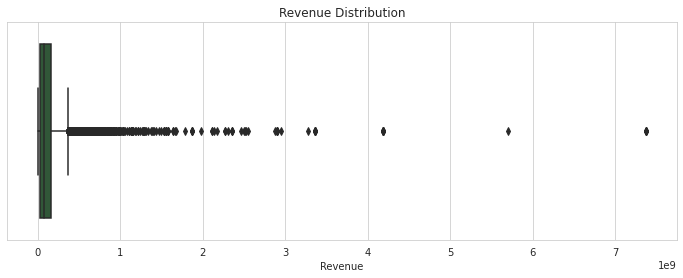

In [130]:
# plot revenue quartiles

sns.boxplot(df['revenue'], color=mp.colors(4))

plt.xlabel('Revenue')
plt.title('Revenue Distribution');

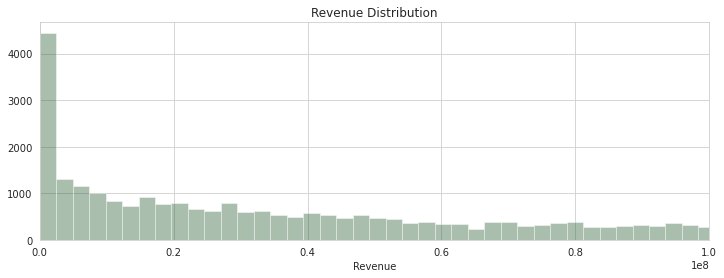

In [131]:
# plot revenue distribution up to $100,000,000

plt.xlim(0, 1e8)

sns.distplot(actor_df['revenue'], bins=3000, color=mp.colors(4), 
             axlabel='Revenue', kde=False)

plt.title('Revenue Distribution');

The last thing I will do to the dataset is rename some of the columns for clarity.

In [132]:
# assign better names to variables
df.rename(columns={'revenue': 'actor_value'}, inplace=True)
df.head(11).transpose()

person_id,2,3,4,5,6,10,12,13,14,18,19
actor_value,1.032727e+09,4.376895e+08,7.803955e+08,1.147836e+09,1.471965e+09,8.530622e+08,7.067063e+08,4.196991e+08,1.212115e+09,3.580708e+08,2.312477e+08
budget,8.725710e+07,8.557983e+07,7.547966e+07,2.398909e+07,1.007536e+08,1.892706e+08,9.858666e+07,6.813673e+07,1.732049e+08,9.392557e+07,4.563826e+07
age,4.668380e+01,5.513486e+01,4.017787e+01,5.970645e+01,4.475702e+01,4.457176e+01,1.042184e+01,5.539010e+01,5.186417e+01,4.845959e+01,5.067192e+01
gender,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
order,8.181818e-01,7.619048e-01,3.000000e+00,1.666667e+00,5.666667e+00,4.500000e+00,4.000000e+00,3.000000e+00,5.000000e-01,5.500000e+00,4.769231e+00
popularity,4.413291e+01,2.541143e+01,3.299827e+01,3.716733e+01,6.011667e+01,3.720150e+01,2.207150e+01,1.732564e+01,2.663600e+01,1.707817e+01,1.613023e+01
release_date,1.997818e+03,1.997190e+03,1.996467e+03,1.972667e+03,1.990333e+03,2.005000e+03,2.004500e+03,2.002364e+03,2.009500e+03,2.008250e+03,2.010000e+03
runtime,1.128182e+02,1.190000e+02,1.152000e+02,9.766667e+01,1.323333e+02,9.400000e+01,9.350000e+01,1.081818e+02,9.850000e+01,9.833333e+01,1.050769e+02
usa,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
vote_average,7.145455e+00,6.730952e+00,6.660000e+00,7.400000e+00,7.483333e+00,7.850000e+00,6.950000e+00,7.018182e+00,7.400000e+00,6.383333e+00,6.584615e+00


In [133]:
# look at final shape
df.shape

(11693, 28)

The only thing left to do for this part of the project is to look for correlations.

In [134]:
# get correlations
df.corr()

,actor_value,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
actor_value,1.000000,0.338427,0.024513,-0.017750,0.003532,0.324761,-0.139160,0.182247,0.011692,0.169662,...,0.114425,0.029130,-0.033335,0.017325,0.002808,0.035594,0.067815,0.020965,0.060309,0.008388
budget,0.338427,1.000000,0.066465,-0.074320,0.056291,0.409427,0.124387,0.303798,-0.030914,0.007143,...,0.272965,0.157006,-0.034252,0.045064,0.105510,0.099853,0.235034,0.160369,0.125105,0.050211
age,0.024513,0.066465,1.000000,-0.220169,0.155521,-0.029201,-0.169383,0.095040,-0.042868,0.061036,...,0.057160,0.114185,-0.003984,0.021496,0.096981,0.095643,0.061719,0.103208,0.084055,0.087139
gender,-0.017750,-0.074320,-0.220169,1.000000,-0.061947,-0.037077,0.067047,-0.019723,0.000895,0.003760,...,-0.049288,-0.101233,-0.008048,0.005427,-0.047672,0.028186,-0.093737,-0.084539,-0.135679,-0.081040
order,0.003532,0.056291,0.155521,-0.061947,1.000000,0.050670,0.021063,0.037384,-0.040459,0.021032,...,-0.160598,-0.119010,-0.140939,-0.112110,-0.139881,-0.193790,-0.158368,-0.177444,-0.107263,-0.079795
popularity,0.324761,0.409427,-0.029201,-0.037077,0.050670,1.000000,0.254630,0.086387,-0.034565,0.116553,...,0.166059,0.054510,0.066870,0.009624,0.084220,0.031203,0.168370,0.117173,0.041942,-0.009119
release_date,-0.139160,0.124387,-0.169383,0.067047,0.021063,0.254630,1.000000,-0.075649,-0.109410,-0.211097,...,0.109729,-0.006507,0.101846,-0.027552,0.075069,0.021267,0.105728,0.125357,-0.050532,-0.108770
runtime,0.182247,0.303798,0.095040,-0.019723,0.037384,0.086387,-0.075649,1.000000,-0.111919,0.331382,...,0.020174,0.245444,-0.111632,0.030301,0.052839,0.081271,0.024763,0.062330,0.212920,0.096127
usa,0.011692,-0.030914,-0.042868,0.000895,-0.040459,-0.034565,-0.109410,-0.111919,1.000000,-0.030831,...,0.005138,-0.040931,0.073568,0.078629,0.062922,0.091337,0.055520,0.073994,-0.033698,0.075435
vote_average,0.169662,0.007143,0.061036,0.003760,0.021032,0.116553,-0.211097,0.331382,-0.030831,1.000000,...,-0.017131,0.087469,-0.143775,0.026150,0.008444,0.024847,-0.048268,-0.037279,0.082396,0.061162


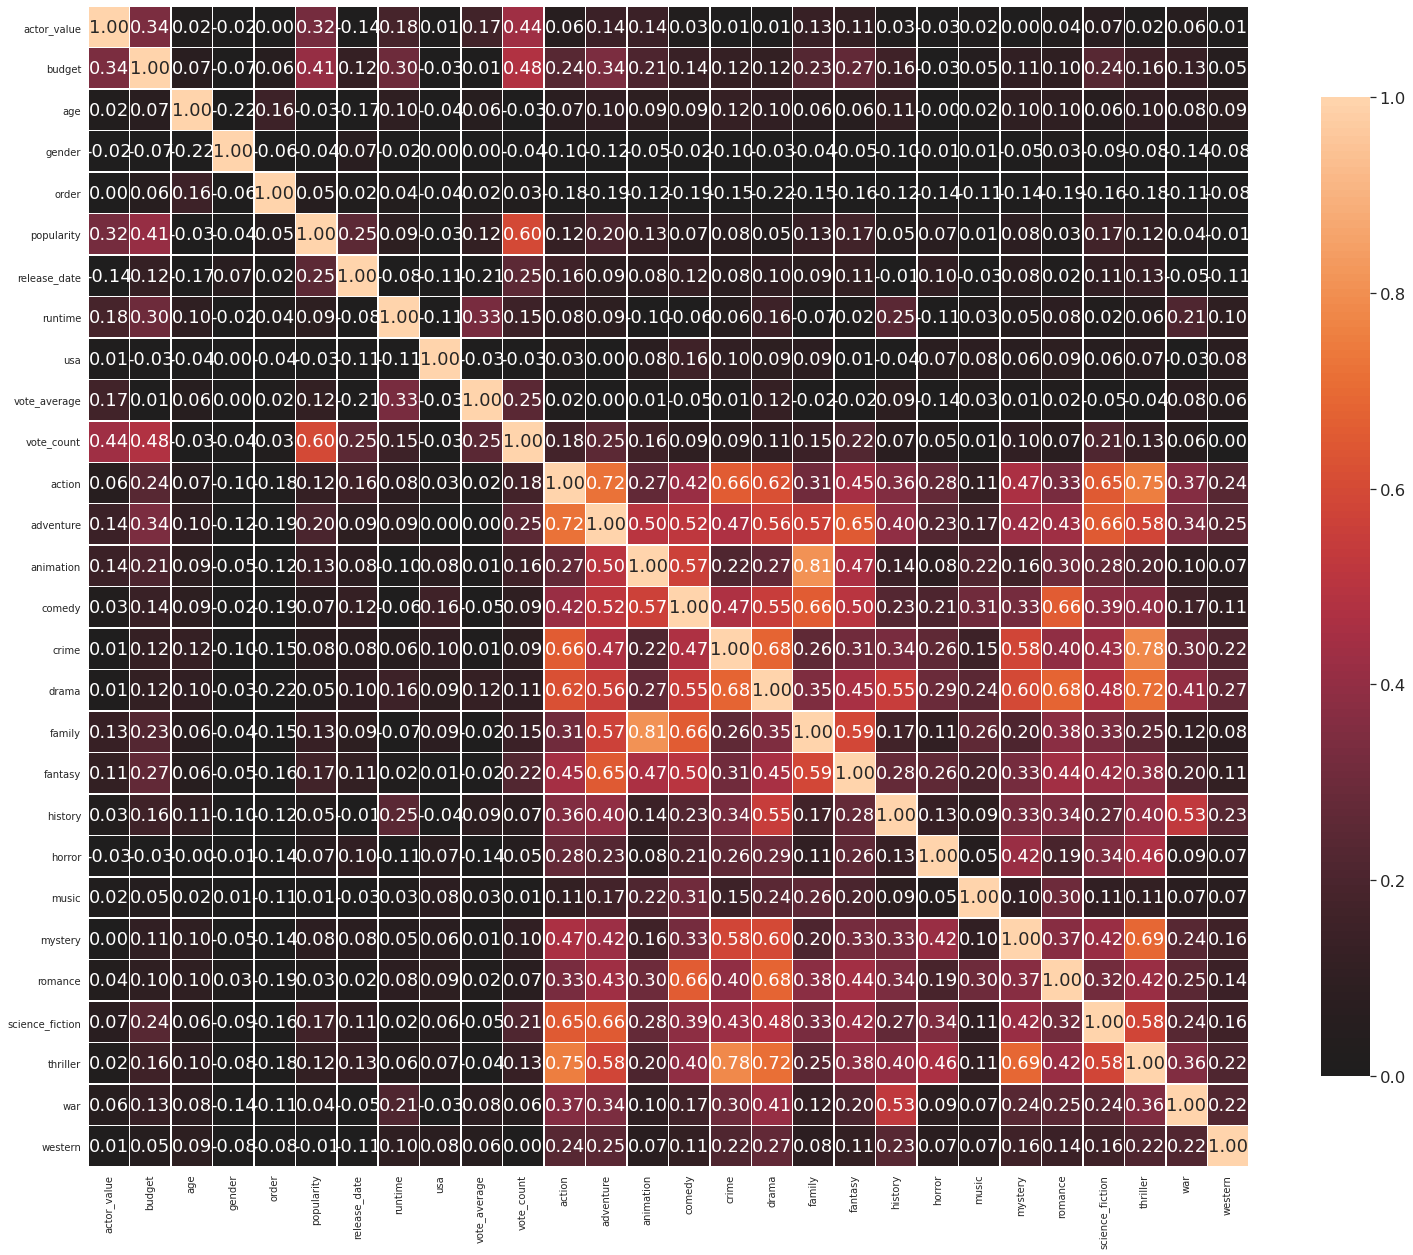

In [135]:
# plot heatmap of correlations
fig, ax = plt.subplots(figsize=(26,30))

sns.set(font_scale=1.5)
sns.heatmap(df.corr(), vmin=0, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=0.5, 
            annot=True, cbar_kws={"shrink": 0.60});

History and war genres are the features most positively correlated with runtime.

The strongest correlation with vote average is the movie budget.

The strongest correlation to release date is popularity.<br>
As popularity is a reflection of current user activity, this makes sense.

As for correlations with the target variable, budget and vote count are the strongest.

In [136]:
# store clean dataset and actor names in JSON
df.to_json('capstone2_ds.json')
actor_df.to_json('capstone2_ref.json')